<a href="https://colab.research.google.com/github/weetittle/loopcreativemarty/blob/main/Copy_of_Optimize_SMA_indicator_Trailing_Profit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import bernoulli
from itertools import product
import random
pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
@dataclass
class Candle:
    open: float
    high: float
    close: float
    low: float
    index: int

@dataclass
class Stats:
    num_trades: int
    win_rate: float
    num_wins: int
    num_losses: int
    perc_return: float
    perc_buy_hold_return: float
    initial_cash: float
    total_profit: float
    def __repr__(self) -> str:
        return f"""
        Number of Trades: {self.num_trades}
        Win Rate: {self.win_rate}%
        Return [%] : {self.perc_return}%
        Buy and Hold Return [%]: {self.perc_buy_hold_return}%
        Total Profit: ${self.total_profit}
        Initial Capital: ${self.initial_cash}
        Winning Trades: {self.num_wins}
        Losing Trades: {self.num_losses}
        """


class Trade:
    def __init__(self, buy_price, buy_index, profit_perc, stop_loss_perc, is_trailing=False):

        self.buy_price = buy_price
        self.sell_price = None
        self.profit = None

        self.buy_index = buy_index
        self.sell_index = None

        self.profit_perc = profit_perc
        self.stop_loss_perc = stop_loss_perc

        self.is_closed = False

        self.take_profit_val = None
        self.take_stop_loss_val = None
        self.is_trailing = is_trailing

        self.update()

    def update(self, curr_candle=None):
        if curr_candle is None:
            self.take_profit_val = self.buy_price * (1 + self.profit_perc)
            self.take_stop_loss_val = self.buy_price * (1 - self.stop_loss_perc)
        else:
            self.take_profit_val = max(self.take_profit_val, curr_candle.open * (1 + self.profit_perc))
            self.take_stop_loss_val = max(self.take_stop_loss_val, curr_candle.open * (1 - self.stop_loss_perc))

    def try_to_close(self, curr_candle):
        if self.is_closed:
            return False

        if curr_candle.low < self.take_stop_loss_val:
            self.close_trade(self.take_stop_loss_val, curr_candle.index)
            return True
        elif curr_candle.high > self.take_profit_val:
            self.close_trade(self.take_profit_val, curr_candle.index)
            return True

        if self.is_trailing:
            self.update(curr_candle)

        return False


    def close_trade(self, sell_price, sell_index):
        self.sell_price = sell_price
        self.sell_index = sell_index
        self.profit = self.sell_price - self.buy_price

        self.is_closed = True


class BaseStrategy:
    def __init__(self, cash):
        self.all_trades = []
        self.cash = cash
        self.init_cash = cash
        # For buy and hold calculation
        self.init_buy_price = None
        self.buy_hold_cash = None
        self.final_buy_price = None

        self.final_stats = None
        self.is_trailing = False


    def buy(self, buy_price, buy_index, profit_perc, stop_loss_perc):
        if buy_price > self.cash:
            return

        new_trade = Trade(buy_price, buy_index, profit_perc, stop_loss_perc, self.is_trailing)
        self.all_trades.append(new_trade)
        self.cash -= buy_price

    def _update_buy_hold_stats(self, curr_candle):
        if not self.init_buy_price:
            self.init_buy_price = curr_candle.open
            self.buy_hold_cash = self.cash - self.init_buy_price

        self.final_buy_price = curr_candle.close


    def run(self, curr_candle, row=None):
        self._update_buy_hold_stats(curr_candle)

        #raise ValueError("Must be implemented by other strategies")

    def force_close(self, curr_candle, row=None):
        for tr in self.all_trades:
            if not tr.is_closed:
                tr.close_trade(sell_price=curr_candle.close, sell_index=curr_candle.index)


    def get_stats(self):
        closed_trades = [tr for tr in self.all_trades if tr.is_closed]
        num_trades = len(closed_trades)
        num_wins = len([tr for tr in closed_trades if  tr.profit > 0])
        total_profit = sum([tr.profit for tr in closed_trades])
        if num_trades > 0:
            win_rate=(num_wins/num_trades) * 100.0
        else:
            win_rate = 0.0

        perc_return = total_profit*100.0/ self.init_cash
        perc_buy_hold_return = ((self.final_buy_price + self.buy_hold_cash) - self.init_cash)*100.0 / self.init_cash


        self.final_stats = Stats(
            num_trades=num_trades,
            num_wins=num_wins,
            num_losses=(num_trades - num_wins),
            win_rate=round(win_rate, 3),
            total_profit=total_profit,
            perc_return= round(perc_return, 3),
            initial_cash=self.init_cash,
            perc_buy_hold_return=round(perc_buy_hold_return, 3)
        )



class RandomStrategy(BaseStrategy):
    def __init__(self, cash, is_trailing=False):
        super().__init__(cash)
        self.is_trailing = is_trailing

    def run(self, curr_candle, row):
        super().run(curr_candle, row)

        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price

        curr_rv = self._get_random_num(state=curr_candle.index)
        if curr_rv:
            self.buy(
                buy_price = curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc = 0.01,
                stop_loss_perc = 0.01,
            )

    def _get_random_num(self, prop=0.5, state=42):
        this_rv = bernoulli.rvs(prop, loc=0, size=1, random_state = state)[0]
        if this_rv == 1:
            return True
        else:
            return False


class RandomSMAStrategy(BaseStrategy):
    def __init__(self, cash, profit_perc=0.01, stop_loss_perc=0.01, is_trailing=False):
        super().__init__(cash)
        self.profit_perc = profit_perc
        self.stop_loss_perc = stop_loss_perc
        self.is_trailing = is_trailing

    def run(self, curr_candle, row):
        super().run(curr_candle, row)

        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price

        curr_rv = self._get_random_num(state=curr_candle.index)
        above_sma = curr_candle.high > row['sma']
        if curr_rv and above_sma:
            self.buy(
                buy_price = curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc = self.profit_perc,
                stop_loss_perc = self.stop_loss_perc,
            )

    def _get_random_num(self, prop=0.5, state=42):
        this_rv = bernoulli.rvs(prop, loc=0, size=1, random_state = state)[0]
        if this_rv == 1:
            return True
        else:
            return False






def candlestick_ax(t, o, h, l, c):
    t_index = list(range(len(t)))

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    color = ["green" if close_price > open_price else "red" for close_price, open_price in zip(c, o)]
    ax.bar(x=t_index, height=h-l, bottom=l, width=0.1, color=color)
    ax.bar(x=t_index, height=np.abs(o-c), bottom=np.min((o,c), axis=0), width=0.6, color=color)


    t_loc = t_index[::72]
    #if type(t[0]) == datetime or type(t[0]) == pd._libs.tslibs.timestamps.Timestamp:
    #    label_loc = [datetime.strftime(x, '%H-%M') for x in t[::12]]
    label_loc = [x[:10] for x in t[::72]]
    ax.set_xticks(ticks=t_loc, labels=label_loc, rotation=45);

    return ax


class BackTest:
    def __init__(self, df, strategy):
        self.df = df
        self.strategy = strategy

    def run_test(self):
        for index, row in self.df.iterrows():
            curr_candle = Candle(open=row['Open'], close=row['Close'], high=row['High'], low=row['Low'], index=row['time_index'])
            self.strategy.run(curr_candle, row)
        self.strategy.force_close(curr_candle, row)

    def show_stats(self, verbose=True):
        self.strategy.get_stats()
        if verbose:
            print(self.strategy.final_stats)


    def visualize(self, verbose=False):
        buy_list =[
            {'buy_time': tr.buy_index, 'sell_time': tr.sell_index, 'buy_price': tr.buy_price, 'sell_price': tr.sell_price,
             'profit': tr.profit}
            for tr in self.strategy.all_trades
        ]
        buy_sell_df = pd.DataFrame(buy_list)
        buy_sell_loss_df = buy_sell_df.query("profit<0")
        if verbose:
            print(buy_sell_df)


        _ax = candlestick_ax(t=self.df['time_str'], o=self.df['Open'], h=self.df['High'], l=self.df['Low'], c=self.df['Close'])
        _ax.plot(buy_sell_df['buy_time'], buy_sell_df['buy_price'], marker=".", markersize=40, color='g', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_df['sell_time'], buy_sell_df['sell_price'], marker=".", markersize=40, color='r', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_loss_df['sell_time'], buy_sell_loss_df['sell_price'], marker="x", markersize=20, color='k', alpha=0.3, linestyle="None")


        return _ax


class Optimizer:
    def __init__(self, optim_strategy='GRID', num_runs=10):
        if optim_strategy not in ['GRID', 'RANDOM']:
            raise ValueError(f"optim_strategy is {optim_strategy}, must be 'GRID' or 'RANDOM'")
        self.optim_strategy = optim_strategy

        self.num_runs = num_runs # only for random
        self.arg_list = []

    def run_optim(self, fn, param_dict, verbose):
        self.fn = fn
        self.params = param_dict

        self.grid = self._expand_param_list()

        if self.optim_strategy == 'RANDOM':
            self.grid = random.sample(self.grid, self.num_runs)

        best_param = None
        best_val = -float("inf")
        total_iter = len(self.grid)

        for counter, elem in enumerate(self.grid):
            res = self.fn(**elem)
            if verbose and counter%5 == 0:
                print(f"Iteration {counter} / {total_iter}")
            if res > best_val:
                best_val = res
                best_param = elem

        return best_param

    def _expand_param_list(self):
        return [dict(zip(self.params.keys(), values)) for values in product(*self.params.values())]





In [ ]:
from itertools import product

# Parameter dictionary
params = {'a': range(10), 'b': range(20), 'c': range(30)}

# Create the grid
grid = [dict(zip(params.keys(), values)) for values in product(*params.values())]

grid[:5]  # Print the first 5 to check


[{'a': 0, 'b': 0, 'c': 0},
 {'a': 0, 'b': 0, 'c': 1},
 {'a': 0, 'b': 0, 'c': 2},
 {'a': 0, 'b': 0, 'c': 3},
 {'a': 0, 'b': 0, 'c': 4}]

## Get the Data

In [ ]:
file_id = '1rsYMnumxTHPyMlPJy45puDV0m7Y0Chxi'
csv_url = f'https://drive.google.com/uc?export=download&id={file_id}'

price_df = pd.read_csv(csv_url, on_bad_lines='warn')

In [ ]:
len(price_df)

8924

In [ ]:
price_df['time_index'] = price_df['loc_index']

In [ ]:
price_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,time,time_str,loc_index,unix_time,Mid,time_index
0,65944.328125,65960.328125,65914.765625,65960.328125,0,0.0,0.0,2024-07-24 00:00:00+00:00,00-00,0,1.721779e+09,65937.546875,0
1,65979.828125,66002.625000,65979.828125,65999.710938,0,0.0,0.0,2024-07-24 00:05:00+00:00,00-05,1,1.721780e+09,65991.226562,1
2,66006.867188,66109.023438,66006.867188,66055.750000,43724800,0.0,0.0,2024-07-24 00:10:00+00:00,00-10,2,1.721780e+09,66057.945312,2
3,66045.406250,66045.406250,66007.835938,66007.835938,0,0.0,0.0,2024-07-24 00:15:00+00:00,00-15,3,1.721780e+09,66026.621094,3
4,66046.625000,66046.625000,65999.812500,66005.453125,0,0.0,0.0,2024-07-24 00:20:00+00:00,00-20,4,1.721780e+09,66023.218750,4


In [ ]:
small_df = price_df.iloc[0:1000]

## Test the Random Strategy

In [ ]:
strategy = RandomStrategy(cash=100000)

In [ ]:
this_backtest = BackTest(df=small_df, strategy=strategy)

In [ ]:
this_backtest.run_test()

In [ ]:
this_backtest.show_stats()


        Number of Trades: 15
        Win Rate: 66.667%
        Return [%] : 2.804%
        Buy and Hold Return [%]: 2.124%
        Total Profit: $2804.4847265624994
        Initial Capital: $100000
        Winning Trades: 10
        Losing Trades: 5
        


    buy_time  sell_time     buy_price    sell_price      profit
0          0        160  65944.328125  66603.771406  659.443281
1        160        226  66488.593750  65823.707812 -664.885938
2        226        277  65847.343750  65188.870313 -658.473437
3        279        301  65391.214844  64737.302695 -653.912148
4        302        457  64346.632812  63703.166484 -643.466328
5        458        461  63506.734375  64141.801719  635.067344
6        463        470  64231.519531  64873.834727  642.315195
7        471        544  64867.152344  65515.823867  648.671523
8        547        580  65548.781250  66204.269062  655.487812
9        580        605  66125.523438  66786.778672  661.255234
10       607        613  66738.164062  67405.545703  667.381641
11       613        744  67261.257812  67933.870391  672.612578
12       745        750  67893.562500  67214.626875 -678.935625
13       750        812  67248.609375  67921.095469  672.486094
14       812        999  67879.085938  6

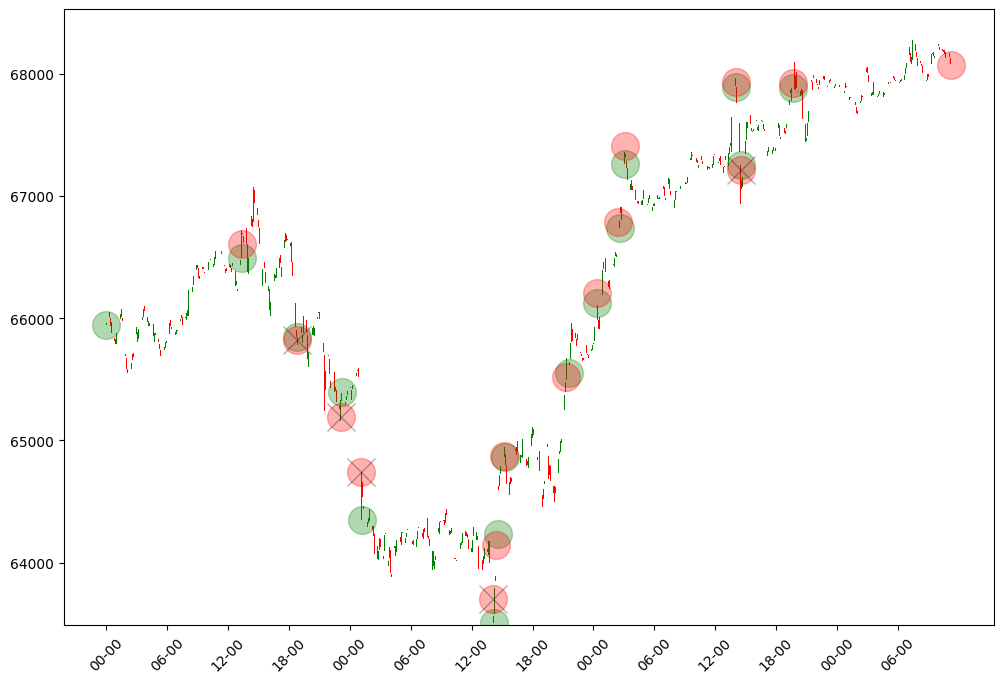

In [ ]:
_ = this_backtest.visualize(True)

## Random Entry with Trailing Stop Loss

In [ ]:
strategy = RandomStrategy(cash=70000, is_trailing=True)

In [ ]:
this_backtest = BackTest(df=small_df, strategy=strategy)

In [ ]:
this_backtest.run_test()

In [ ]:
this_backtest.show_stats()


        Number of Trades: 9
        Win Rate: 44.444%
        Return [%] : 4.33%
        Buy and Hold Return [%]: 3.035%
        Total Profit: $3031.195585937501
        Initial Capital: $70000
        Winning Trades: 4
        Losing Trades: 5
        


   buy_time  sell_time     buy_price    sell_price       profit
0         0        185  65944.328125  66374.279297   429.951172
1       186        224  66385.554688  66016.123594  -369.431094
2       226        258  65847.343750  65406.183047  -441.160703
3       259        301  65570.679688  65034.639141  -536.040547
4       302        336  64346.632812  63945.031992  -401.600820
5       337        455  63904.535156  63790.777617  -113.757539
6       458        514  63506.734375  64469.275664   962.541289
7       516        750  64551.195312  67231.975078  2680.779766
8       750        999  67248.609375  68068.523438   819.914062


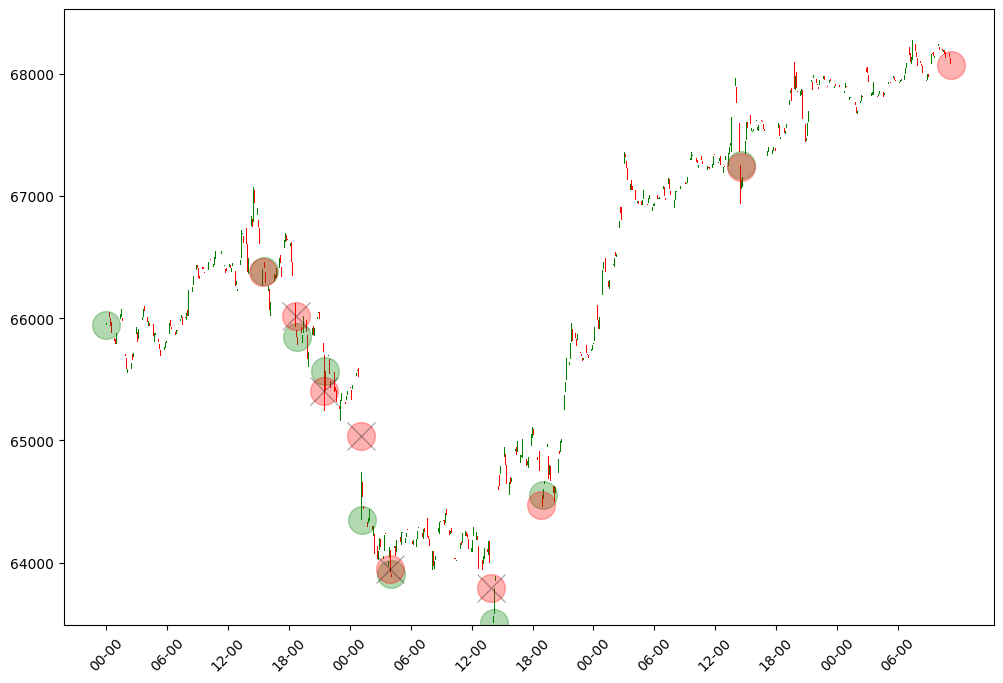

In [ ]:
_ = this_backtest.visualize(True)

## Entry based on Moving Average (No Trailing Stop)

In [ ]:
small_df['sma'] = small_df['Mid'].rolling(50).mean()

In [ ]:
small_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,time,time_str,loc_index,unix_time,Mid,time_index,sma
0,65944.328125,65960.328125,65914.765625,65960.328125,0,0.0,0.0,2024-07-24 00:00:00+00:00,00-00,0,1.721779e+09,65937.546875,0,NaN
1,65979.828125,66002.625000,65979.828125,65999.710938,0,0.0,0.0,2024-07-24 00:05:00+00:00,00-05,1,1.721780e+09,65991.226562,1,NaN
2,66006.867188,66109.023438,66006.867188,66055.750000,43724800,0.0,0.0,2024-07-24 00:10:00+00:00,00-10,2,1.721780e+09,66057.945312,2,NaN
3,66045.406250,66045.406250,66007.835938,66007.835938,0,0.0,0.0,2024-07-24 00:15:00+00:00,00-15,3,1.721780e+09,66026.621094,3,NaN
4,66046.625000,66046.625000,65999.812500,66005.453125,0,0.0,0.0,2024-07-24 00:20:00+00:00,00-20,4,1.721780e+09,66023.218750,4,NaN


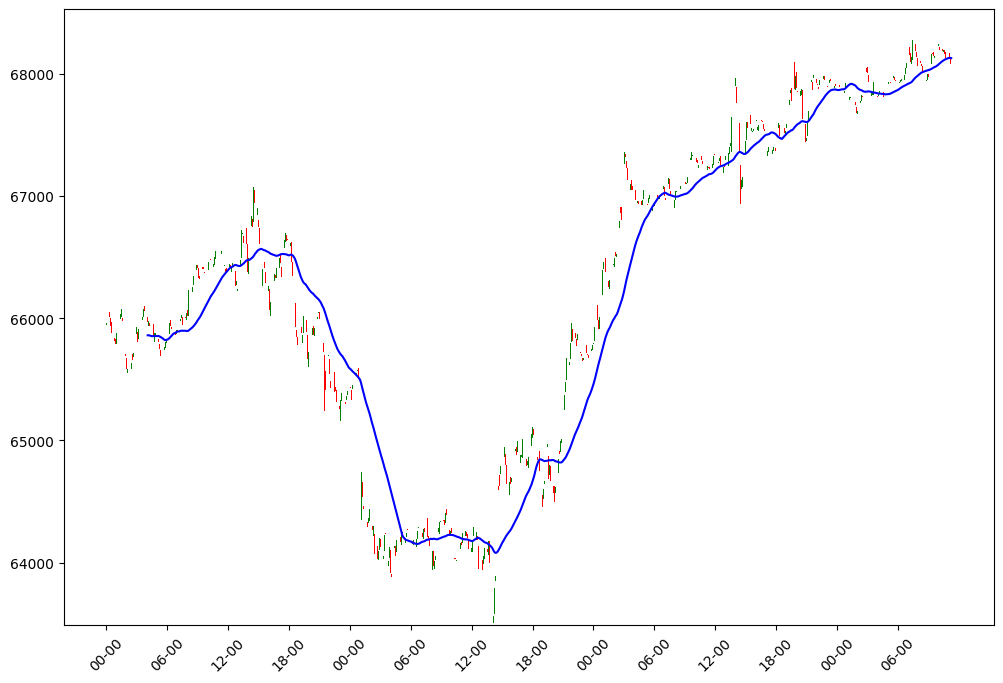

In [ ]:
# lets first visualize how the moving average is going to look like
_ax = candlestick_ax(t=small_df['time_str'], o=small_df['Open'], h=small_df['High'], l=small_df['Low'], c=small_df['Close'])
_ax.plot(small_df['loc_index'], small_df['sma'], 'b-')

In [ ]:
strategy_2 = RandomSMAStrategy(cash=70000)

In [ ]:
this_backtest_2 = BackTest(df=small_df, strategy=strategy_2)

In [ ]:
this_backtest_2.run_test()

In [ ]:
this_backtest_2.show_stats()


        Number of Trades: 13
        Win Rate: 69.231%
        Return [%] : 3.93%
        Buy and Hold Return [%]: 3.035%
        Total Profit: $2751.113085937497
        Initial Capital: $70000
        Winning Trades: 9
        Losing Trades: 4
        


    buy_time  sell_time     buy_price    sell_price      profit
0         51        160  65957.210938  66616.783047  659.572109
1        160        226  66488.593750  65823.707812 -664.885938
2        293        301  65574.585938  64918.840078 -655.745859
3        352        457  64250.035156  63607.534805 -642.500352
4        463        470  64231.519531  64873.834727  642.315195
5        471        544  64867.152344  65515.823867  648.671523
6        547        580  65548.781250  66204.269062  655.487812
7        580        605  66125.523438  66786.778672  661.255234
8        607        613  66738.164062  67405.545703  667.381641
9        613        744  67261.257812  67933.870391  672.612578
10       745        750  67893.562500  67214.626875 -678.935625
11       756        813  67338.476562  68011.861328  673.384766
12       813        999  67956.023438  68068.523438  112.500000


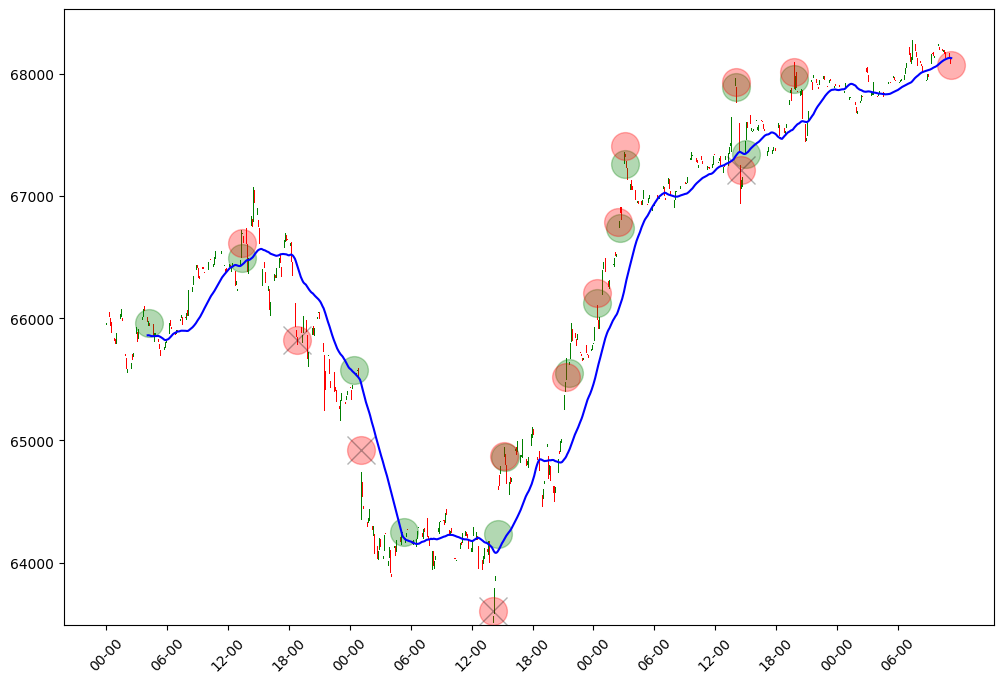

In [ ]:
_ax2 = this_backtest_2.visualize(True)
_ax2.plot(small_df['loc_index'], small_df['sma'], 'b-')

## Entry Based on Moving Average (with Trailing Stop)

In [ ]:
strategy_21 = RandomSMAStrategy(cash=70000, is_trailing = True)
this_backtest_21 = BackTest(df=small_df, strategy=strategy_21)
this_backtest_21.run_test()
this_backtest_21.show_stats()


        Number of Trades: 7
        Win Rate: 57.143%
        Return [%] : 3.092%
        Buy and Hold Return [%]: 3.035%
        Total Profit: $2164.4702343750105
        Initial Capital: $70000
        Winning Trades: 4
        Losing Trades: 3
        


   buy_time  sell_time     buy_price    sell_price       profit
0        51        185  65957.210938  66374.279297   417.068359
1       209        224  66508.445312  66016.123594  -492.321719
2       293        301  65574.585938  64932.792891  -641.793047
3       352        455  64250.035156  63790.777617  -459.257539
4       463        514  64231.519531  64469.275664   237.756133
5       521        750  64859.003906  67231.975078  2372.971172
6       756        999  67338.476562  68068.523438   730.046875


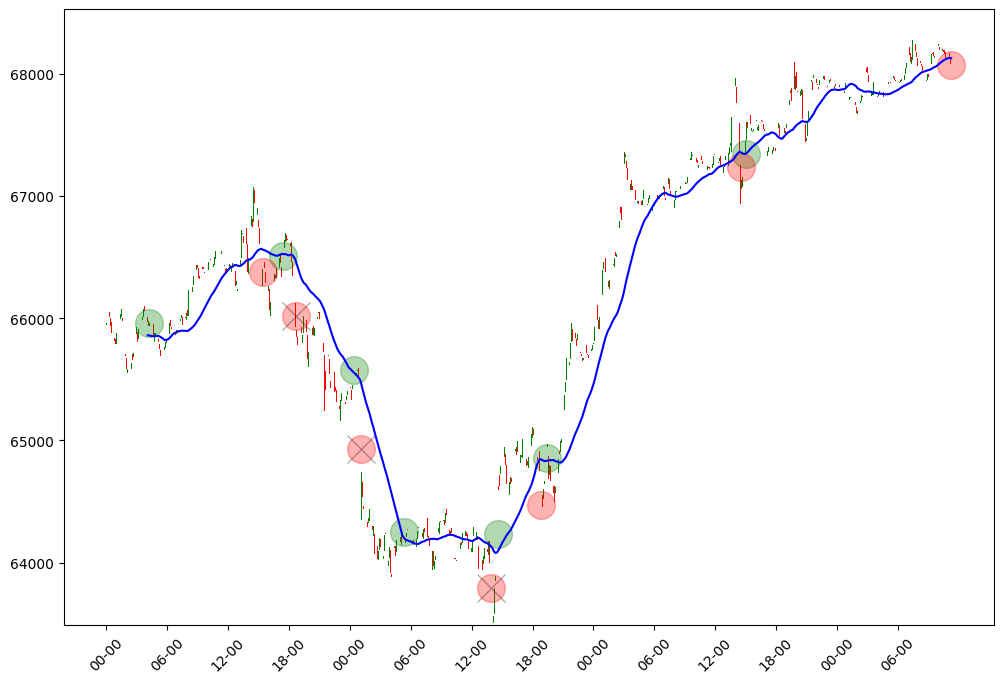

In [ ]:
_ax2 = this_backtest_21.visualize(True)
_ax2.plot(small_df['loc_index'], small_df['sma'], 'b-')

# Try a Larger TimeFrame

In [ ]:
small_df2 = price_df.iloc[2000:7000]
small_df2['sma'] = small_df2['Mid'].rolling(50).mean()

In [ ]:
strategy3 = RandomStrategy(cash=80000)
this_backtest3 = BackTest(df=small_df2, strategy=strategy3)
this_backtest3.run_test()
this_backtest3.show_stats()


        Number of Trades: 200
        Win Rate: 44.5%
        Return [%] : -17.633%
        Buy and Hold Return [%]: -8.804%
        Total Profit: $-14106.730468750007
        Initial Capital: $80000
        Winning Trades: 89
        Losing Trades: 111
        


In [ ]:
strategy4 = RandomSMAStrategy(cash=80000)
this_backtest4 = BackTest(df=small_df2, strategy=strategy4)
this_backtest4.run_test()
this_backtest4.show_stats()


        Number of Trades: 119
        Win Rate: 48.739%
        Return [%] : -3.202%
        Buy and Hold Return [%]: -8.804%
        Total Profit: $-2561.8374218749814
        Initial Capital: $80000
        Winning Trades: 58
        Losing Trades: 61
        


In [ ]:
strategy5 = RandomSMAStrategy(cash=80000, is_trailing=True)
this_backtest5 = BackTest(df=small_df2, strategy=strategy5)
this_backtest5.run_test()
this_backtest5.show_stats()


        Number of Trades: 103
        Win Rate: 42.718%
        Return [%] : 3.751%
        Buy and Hold Return [%]: -8.804%
        Total Profit: $3000.4278124999764
        Initial Capital: $80000
        Winning Trades: 44
        Losing Trades: 59
        


## Optimize the Strategy

In [ ]:
def opt_fn(profit_perc, stop_loss_perc, sma_val):
    small_df2 = price_df.iloc[0:2000]
    small_df2['sma'] = small_df2['Mid'].rolling(sma_val).mean()
    strategy44 = RandomSMAStrategy(cash=80000, profit_perc=profit_perc, stop_loss_perc=stop_loss_perc, is_trailing=True)
    this_backtest44 = BackTest(df=small_df2, strategy=strategy44)
    this_backtest44.run_test()
    this_backtest44.show_stats(verbose=False)

    return strategy44.final_stats.perc_return





In [ ]:
opt_fn(profit_perc=0.01, stop_loss_perc=0.01, sma_val=13)

3.181

In [ ]:
param_dict = {
    'profit_perc': [0.001,0.005, 0.01, 0.015, 0.02, 0.025, 0.05],
    'stop_loss_perc': [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05],
    'sma_val': [5, 14, 20, 33,50, 100, 150, 200, 250]
}

my_optim = Optimizer(optim_strategy='RANDOM', num_runs=50)
best_params = my_optim.run_optim(fn=opt_fn, param_dict=param_dict, verbose=True)


Iteration 0 / 50
Iteration 5 / 50
Iteration 10 / 50
Iteration 15 / 50
Iteration 20 / 50
Iteration 25 / 50
Iteration 30 / 50
Iteration 35 / 50
Iteration 40 / 50
Iteration 45 / 50


In [ ]:
best_params

{'profit_perc': 0.005, 'stop_loss_perc': 0.001, 'sma_val': 14}

In [ ]:
small_df2 = price_df.iloc[2000:7000]
small_df2['sma'] = small_df2['Mid'].rolling(14).mean()
strategy6 = RandomSMAStrategy(cash=10000, profit_perc=0.005, stop_loss_perc=0.001, is_trailing=True)
this_backtest6 = BackTest(df=small_df2, strategy=strategy6)
this_backtest6.run_test()
this_backtest6.show_stats()


        Number of Trades: 0
        Win Rate: 0.0%
        Return [%] : 0.0%
        Buy and Hold Return [%]: -70.433%
        Total Profit: $0
        Initial Capital: $10000
        Winning Trades: 0
        Losing Trades: 0
        
